# Morans I analysis

In [8]:
%matplotlib inline

import geopandas as gpd
from geopandas import GeoDataFrame
import numpy as np
import pandas as pd
import contextily as ctx
import gtfs_kit as gk
import shapely
import rtree
import xarray as xr
from shapely.geometry import mapping
from shapely.ops import unary_union
import h3
import base64
import urllib
import tempfile
import networkx as nx
from csv import DictReader
from itertools import groupby
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from splot.esda import (
    moran_scatterplot, lisa_cluster, plot_local_autocorrelation, plot_moran
)
from splot.libpysal import plot_spatial_weights
from pysal.lib import weights
import esda
plot_moran

<function splot._viz_esda_mpl.plot_moran(moran, zstandard=True, aspect_equal=True, scatter_kwds=None, fitline_kwds=None, **kwargs)>

# Morans I reagrding accesibility for the county

In [9]:
gdf = gpd.read_parquet("county_gdf.parquet")

In [10]:
w_gdf = gdf[["GEOID", "geometry"]].merge(gdf.groupby("GEOID").accessibility_score.agg("sum").reset_index()).drop_duplicates()

In [11]:
w_gdf["log_accessibility_score"] = np.log(w_gdf["accessibility_score"] + 1)

In [12]:
w_gdf.head()

,GEOID,geometry,accessibility_score,log_accessibility_score
0,36047000700,"POLYGON ((-74.00154 40.69279, -74.00132 40.693...",5.943061,1.937743
1,36047000900,"POLYGON ((-73.99405 40.69090, -73.99374 40.691...",7.414944,2.130009
2,36047001100,"POLYGON ((-73.99073 40.69305, -73.99045 40.693...",27.437925,3.347724
5,36047001300,"POLYGON ((-73.99141 40.69863, -73.99131 40.699...",14.136360,2.717100
7,36047002000,"POLYGON ((-74.01867 40.64741, -74.01809 40.647...",4.814177,1.760299


In [13]:
w_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3390 entries, 0 to 15924
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   GEOID                    3390 non-null   object  
 1   geometry                 3390 non-null   geometry
 2   accessibility_score      3390 non-null   float64 
 3   log_accessibility_score  3390 non-null   float64 
dtypes: float64(2), geometry(1), object(1)
memory usage: 132.4+ KB


In [14]:
w = weights.Queen.from_dataframe(w_gdf, idVariable="GEOID")

/Users/viktortorpthomsen/opt/anaconda3/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 36081091603, 36081107201.
  warnings.warn(message)


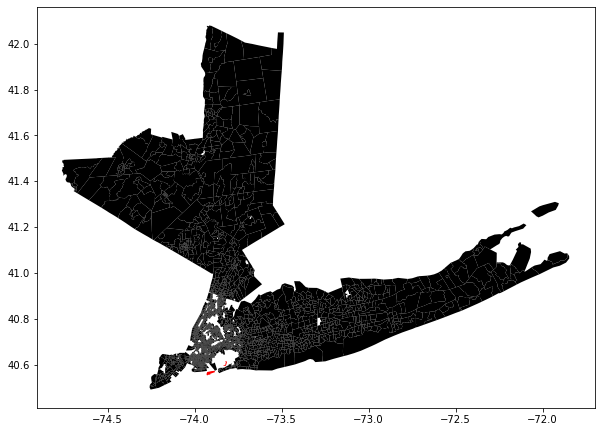

In [15]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax = w_gdf.loc[~w_gdf.GEOID.isin(w.islands), :].plot(color='black', ax=ax)
ax = w_gdf.loc[w_gdf.GEOID.isin(w.islands), :].plot(color='red', ax=ax)
plt.show()

In [16]:
w_gdf = w_gdf.loc[~w_gdf.GEOID.isin(w.islands), :].reset_index(drop=True)

In [17]:
%time w = weights.Queen.from_dataframe(w_gdf, idVariable="GEOID")

CPU times: user 1.69 s, sys: 56.6 ms, total: 1.74 s
Wall time: 1.75 s


In [18]:
lisa = esda.Moran_Local(w_gdf["log_accessibility_score"], w)

(<Figure size 1152x720 with 3 Axes>,
 array([<AxesSubplot:title={'center':'Moran Local Scatterplot'}, xlabel='Attribute', ylabel='Spatial Lag'>,
        <AxesSubplot:>, <AxesSubplot:>], dtype=object))

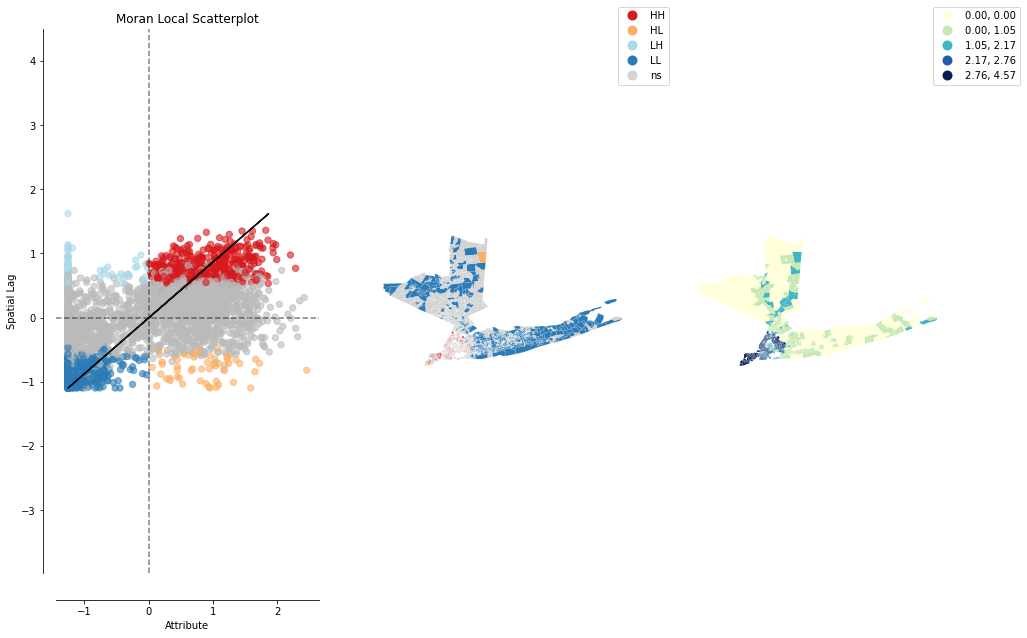

In [19]:
plot_local_autocorrelation(lisa, w_gdf, "log_accessibility_score", figsize=(16, 10))

In [20]:
mi = esda.Moran(w_gdf["log_accessibility_score"], w)
mi.I, mi.p_sim

(0.39730660892225406, 0.001)

(<Figure size 720x288 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Reference Distribution'}, xlabel='Moran I: 0.4', ylabel='Density'>,
        <AxesSubplot:title={'center':'Moran Scatterplot (0.4)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

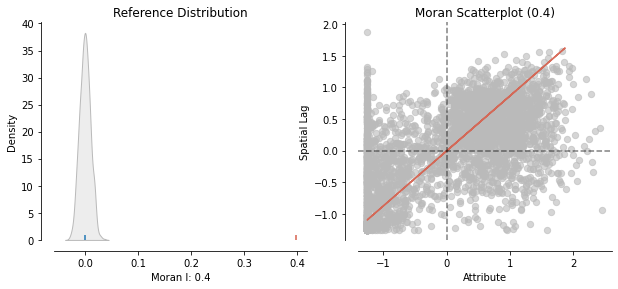

In [21]:
plot_moran(mi)

# Morans I reagrding accesibility for the city

In [22]:
gdf = gpd.read_parquet("city_gdf.parquet")

In [23]:
w_gdf = gdf[["GEOID", "geometry"]].merge(gdf.groupby("GEOID").accessibility_score.agg("sum").reset_index()).drop_duplicates()

In [24]:
w_gdf["log_accessibility_score"] = np.log(w_gdf["accessibility_score"] + 1)

In [25]:
w_gdf.head()

,GEOID,geometry,accessibility_score,log_accessibility_score
0,36047000700,"POLYGON ((-74.00154 40.69279, -74.00132 40.693...",5.943061,1.937743
1,36047000900,"POLYGON ((-73.99405 40.69090, -73.99374 40.691...",7.414944,2.130009
2,36047001100,"POLYGON ((-73.99073 40.69305, -73.99045 40.693...",27.437925,3.347724
5,36047001300,"POLYGON ((-73.99141 40.69863, -73.99131 40.699...",14.136360,2.717100
7,36047002000,"POLYGON ((-74.01867 40.64741, -74.01809 40.647...",4.814177,1.760299


In [26]:
w_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2216 entries, 0 to 6962
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   GEOID                    2216 non-null   object  
 1   geometry                 2216 non-null   geometry
 2   accessibility_score      2216 non-null   float64 
 3   log_accessibility_score  2216 non-null   float64 
dtypes: float64(2), geometry(1), object(1)
memory usage: 86.6+ KB


In [27]:
w = weights.Queen.from_dataframe(w_gdf, idVariable="GEOID")

/Users/viktortorpthomsen/opt/anaconda3/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There are 2 islands with ids: 36081091603, 36081107201.
  warnings.warn(message)


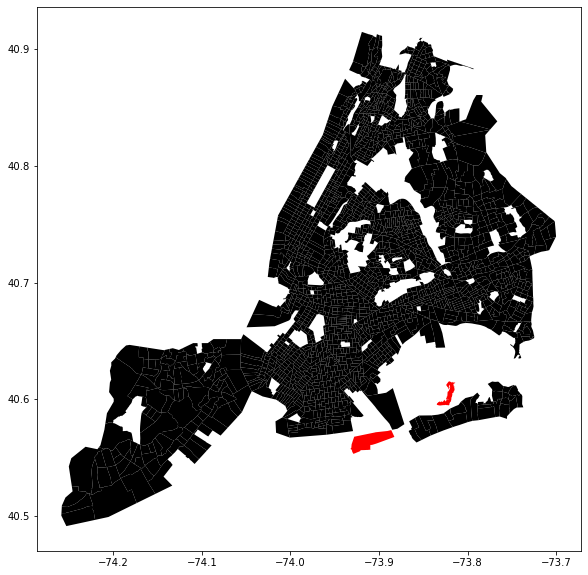

In [28]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax = w_gdf.loc[~w_gdf.GEOID.isin(w.islands), :].plot(color='black', ax=ax)
ax = w_gdf.loc[w_gdf.GEOID.isin(w.islands), :].plot(color='red', ax=ax)
plt.show()

In [29]:
w_gdf = w_gdf.loc[~w_gdf.GEOID.isin(w.islands), :].reset_index(drop=True)

In [30]:
%time w = weights.Queen.from_dataframe(w_gdf, idVariable="GEOID")

CPU times: user 414 ms, sys: 12 ms, total: 426 ms
Wall time: 426 ms


/Users/viktortorpthomsen/opt/anaconda3/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


In [31]:
lisa = esda.Moran_Local(w_gdf["log_accessibility_score"], w)

(<Figure size 1152x720 with 3 Axes>,
 array([<AxesSubplot:title={'center':'Moran Local Scatterplot'}, xlabel='Attribute', ylabel='Spatial Lag'>,
        <AxesSubplot:>, <AxesSubplot:>], dtype=object))

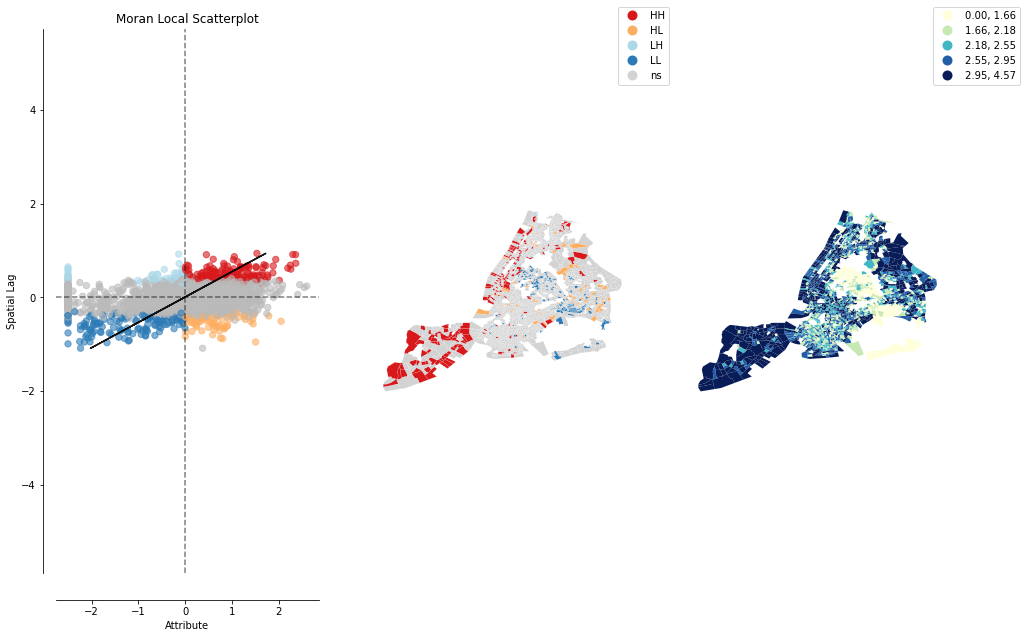

In [32]:
plot_local_autocorrelation(lisa, w_gdf, "log_accessibility_score", figsize=(16, 10))

In [33]:
mi = esda.Moran(w_gdf["log_accessibility_score"], w)
mi.I, mi.p_sim

(0.16317810224148618, 0.001)

(<Figure size 720x288 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Reference Distribution'}, xlabel='Moran I: 0.16', ylabel='Density'>,
        <AxesSubplot:title={'center':'Moran Scatterplot (0.16)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

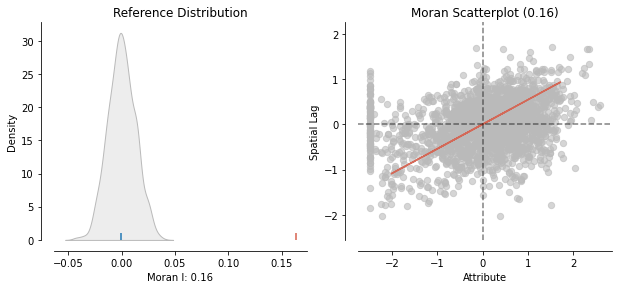

In [34]:
plot_moran(mi)